Este Práctico fue realizado por Quiros Agustina, Porcel Carolina y Peralta Agustín

In [1]:
import gzip
import pandas as pd
import tempfile
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import bz2
import mlflow
from gensim import corpora
from gensim.parsing import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import average_precision_score
from sklearn import metrics
from sklearn.metrics import balanced_accuracy_score
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm, trange

In [2]:
class MelichanllegeDataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform
    
    def __len__(self):
        return self.dataset.shape[0]

    def __getitem__(self, item):
        if torch.is_tensor(item):
            item = item.to_list()
        
        item = {
            "data": self.dataset.loc[item, "title"],
            "target": self.dataset.loc[item, "category"]
        }
        
        if self.transform:
            item = self.transform(item)
        
        return item

# dataset = MelichanllegeDataset("/users/aperalta/Practicos/Practico_1/meli-challenge-2019/spanish.train.jsonl")
# print(f"Dataset loaded with {len(dataset)} elements")
# print(f"Sample element:\n{dataset[0]}")

In [3]:
class RawDataProcessor:
    def __init__(self, 
                 dataset, 
                 ignore_header=True, 
                 filters=None, 
                 vocab_size=50000):
        if filters:
            self.filters = filters
        else:
            self.filters = [
                lambda s: s.lower(),
                preprocessing.strip_tags,
                preprocessing.strip_punctuation,
                preprocessing.strip_multiple_whitespaces,
                preprocessing.strip_numeric,
                preprocessing.remove_stopwords,
                preprocessing.strip_short,
            ]
        
        # Create dictionary based on all the reviews (with corresponding preprocessing)
        # https://radimrehurek.com/gensim/corpora/dictionary.html
        self.dictionary = corpora.Dictionary(
            dataset["title"].map(self._preprocess_string).tolist()
        )
        # Filter the dictionary with extremos words
        # https://tedboy.github.io/nlps/generated/generated/gensim.corpora.Dictionary.filter_extremes.html?highlight=filter_extrem
        self.dictionary.filter_extremes(no_below=2, no_above=1, keep_n=vocab_size)
        
        # Make the indices continuous after some words have been removed
        # https://tedboy.github.io/nlps/generated/generated/gensim.corpora.Dictionary.compactify.html
        self.dictionary.compactify()
        
        # Add a couple of special tokens
        self.dictionary.patch_with_special_tokens({
            "[PAD]": 0,
            "[UNK]": 1
        })
        self.idx_to_target = sorted(dataset["category"].unique())
        self.target_to_idx = {t: i for i, t in enumerate(self.idx_to_target)}


    def _preprocess_string(self, string):
        # https://radimrehurek.com/gensim/parsing/preprocessing.html#gensim.parsing.preprocessing.preprocess_string:~:text=gensim.parsing.preprocessing.preprocess_string
        return preprocessing.preprocess_string(string, filters=self.filters)

    def _sentence_to_indices(self, sentence):
      # https://radimrehurek.com/gensim/corpora/dictionary.html#:~:text=doc2idx(document,via%20unknown_word_index.
        return self.dictionary.doc2idx(sentence, unknown_word_index=1)
    
    def encode_data(self, data):
        return self._sentence_to_indices(self._preprocess_string(data))
    
    def encode_target(self, target):
        return self.target_to_idx[target]
    
    def __call__(self, item):
        if isinstance(item["data"], str):
            data = self.encode_data(item["data"])
        else:
            data = [self.encode_data(d) for d in item["data"]]
        
        if isinstance(item["target"], str):
            target = self.encode_target(item["target"])
        else:
            target = [self.encode_target(t) for t in item["target"]]
        
        return {
            "data": data,
            "target": target
        }

In [4]:
dataset_train = pd.read_json("/users/aperalta/Practicos/Practico_1/meli-challenge-2019/spanish.train.jsonl",lines=True, orient='records')

In [5]:
dataset_test = pd.read_json("/users/aperalta/Practicos/Practico_1/meli-challenge-2019/spanish.validation.jsonl",lines=True, orient='records')

In [6]:
dataset_val = pd.read_json("/users/aperalta/Practicos/Practico_1/meli-challenge-2019/spanish.test.jsonl",lines=True, orient='records')

In [7]:
dataset = pd.concat([dataset_train,dataset_test])

In [8]:
preprocess = RawDataProcessor(dataset)

In [9]:
train_dataset = MelichanllegeDataset(dataset_train, transform=preprocess)

In [10]:
test_dataset = MelichanllegeDataset(dataset_test, transform=preprocess)

In [11]:
val_dataset = MelichanllegeDataset(dataset_val, transform=preprocess)

In [12]:
class PadSequences:
    def __init__(self, pad_value=0, max_length=None, min_length=1):
        assert max_length is None or min_length <= max_length
        self.pad_value = pad_value
        self.max_length = max_length
        self.min_length = min_length

    def __call__(self, items):
        data, target = list(zip(*[(item["data"], item["target"]) for item in items]))
        seq_lengths = [len(d) for d in data]

        if self.max_length:
            max_length = self.max_length
            seq_lengths = [min(self.max_length, l) for l in seq_lengths]
        else:
            max_length = max(self.min_length, max(seq_lengths))

        data = [d[:l] + [self.pad_value] * (max_length - l)
                for d, l in zip(data, seq_lengths)]
            
        return {
            "data": torch.LongTensor(data),
            "target": torch.FloatTensor(target)
        }

In [13]:
pad_sequences = PadSequences()
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True,
                          collate_fn=pad_sequences, drop_last=False, num_workers = 0)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False,
                         collate_fn=pad_sequences, drop_last=False, num_workers = 0)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False,
                         collate_fn=pad_sequences, drop_last=False, num_workers = 0)

In [14]:
class MeliLSTM(nn.Module):
    def __init__(self,
                 pretrained_embeddings_path, dictionary, embedding_size,
                 hidden_layer=32,
                 num_layers=1, dropout=0., bias=True,
                 bidirectional=False,
                 freeze_embedings=True):
        
        super(MeliLSTM, self).__init__()
        output_size = 632
        # Create the Embeddings layer and add pre-trained weights
        embeddings_matrix = torch.randn(len(dictionary), embedding_size)
        embeddings_matrix[0] = torch.zeros(embedding_size)
        with bz2.open(pretrained_embeddings_path, "rt") as fh:
            for line in fh:
                word, vector = line.strip().split(None, 1)
                if word in dictionary.token2id:
                    embeddings_matrix[dictionary.token2id[word]] =\
                        torch.FloatTensor([float(n) for n in vector.split()])
        self.embedding_config = {'freeze': freeze_embedings,
                                  'padding_idx': 0}
        self.embeddings = nn.Embedding.from_pretrained(
            embeddings_matrix, **self.embedding_config)
        
        # Set our LSTM parameters
        self.lstm_config = {'input_size': embedding_size,
                            'hidden_size': hidden_layer,
                            'num_layers': num_layers,
                            'bias': bias,
                            'batch_first': True,
                            'dropout': dropout,
                            'bidirectional': bidirectional}
        
        # Set our fully connected layer parameters
        self.linear_config = {'in_features': hidden_layer,
                              'out_features': output_size,
                              'bias': bias}
        
        # Instanciate the layers
        self.lstm = nn.LSTM(**self.lstm_config)
        self.classification_layer = nn.Linear(**self.linear_config)
        #self.activation = nn.Sigmoid()

    def forward(self, inputs):
        emb = self.embeddings(inputs)
        # print(emb.shape)
        lstm_out, _ = self.lstm(emb)
        # print(lstm_out.shape)
        # Take last state of lstm, which is a representation of
        # the entire text
        lstm_out = lstm_out[:, -1, :].squeeze()
        # print(lstm_out.shape)
        predictions = self.classification_layer(lstm_out)
        # print(prediction.shape)
        return predictions

In [15]:
model = MeliLSTM(
    "/users/aperalta/Practicos/Practico_1/data/SBW-vectors-300-min5.txt.bz2", preprocess.dictionary,
    embedding_size=300,
    hidden_layer=64,
    num_layers=1,
    dropout=0.1
)
print(model)

MeliLSTM(
  (embeddings): Embedding(50002, 300, padding_idx=0)
  (lstm): LSTM(300, 64, batch_first=True, dropout=0.1)
  (classification_layer): Linear(in_features=64, out_features=632, bias=True)
)


/users/aperalta/miniconda3/envs/deeplearning/lib/python3.9/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [16]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [17]:
model.to(device)

MeliLSTM(
  (embeddings): Embedding(50002, 300, padding_idx=0)
  (lstm): LSTM(300, 64, batch_first=True, dropout=0.1)
  (classification_layer): Linear(in_features=64, out_features=632, bias=True)
)

In [18]:
def train_and_eval(model, optimizer, loss_function, trainloader, epochs,
                   valloader, use_tqdm=True):
    history = {'train_loss': [], 'val_loss': [], 'val_b_accuracy': []}
    for epoch in range(epochs):  # loop over the dataset multiple times
        model.train()
        running_loss = 0.0
        pbar = tqdm(trainloader) if use_tqdm else trainloader
        for step, data in enumerate(pbar, 1):
            # get the inputs; data is a list of [inputs, labels]
            inputs = data["data"].to(device)
            labels = data["target"].to(device)
            # zero the parameter gradients
            optimizer.zero_grad()
            # forward + backward + optimize
            outputs = model(inputs)
            loss = loss_function(outputs, labels.squeeze().long())
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if use_tqdm and step > 0 and step % 50 == 0:
                pbar.set_description(
                    f"[{epoch + 1}, {step}] loss: {running_loss / step:.4g}")
        history['train_loss'].append((epoch, running_loss / step))

        # At the end of the epoch, evaluate model on validation
        model.eval();  # Activate evaluation mode
        running_loss = 0.0
        y_true = []
        y_pred = []
        with torch.no_grad():
            pbar = tqdm(valloader) if use_tqdm else valloader
            for step, data in enumerate(pbar, 1):
                inputs = data["data"].to(device)
                labels = data["target"].to(device)
                outputs = model(inputs)
                running_loss += loss_function(outputs, labels.squeeze().long()).item()
                _, predicted = torch.max(outputs.data, 1)
                y_true.extend(labels.cpu().numpy())
                y_pred.extend(predicted.cpu().numpy())
        history['val_b_accuracy'].append(metrics.balanced_accuracy_score(y_true, y_pred))
        history['val_loss'].append((epoch, running_loss / step))
    
    return history

In [19]:
def run_experiment3(model, epochs, trainloader, testloader,
                    optimizer_class=optim.SGD, lr=0.001, weight_decay=0.0,
                    use_tqdm=True):
    loss_function = nn.CrossEntropyLoss()
    optimizer = optimizer_class(model.parameters(), lr=lr,
                                weight_decay=weight_decay)
    history = train_and_eval(
        model, optimizer, loss_function, trainloader, epochs,
        valloader=testloader, use_tqdm=use_tqdm)
    #test_results = eval(model, testloader, use_tqdm=use_tqdm)

    experiment = {
        'arquitecture': str(model), 'loss': str(loss_function),
        'epochs': epochs, 'lr': lr, 'optimizer': str(optimizer_class),
        'weight_decay': weight_decay
    }
    experiment.update(history)
    #experiment.update(test_results)
    return experiment

In [20]:
experiment=run_experiment3(model,5, train_loader, test_loader,optimizer_class=optim.Adam, lr=0.001)

  0%|          | 0/76489 [00:00<?, ?it/s]

  0%|          | 0/19123 [00:00<?, ?it/s]

  0%|          | 0/76489 [00:00<?, ?it/s]

  0%|          | 0/19123 [00:00<?, ?it/s]

  0%|          | 0/76489 [00:00<?, ?it/s]

  0%|          | 0/19123 [00:00<?, ?it/s]

  0%|          | 0/76489 [00:00<?, ?it/s]

  0%|          | 0/19123 [00:00<?, ?it/s]

  0%|          | 0/76489 [00:00<?, ?it/s]

  0%|          | 0/19123 [00:00<?, ?it/s]

In [21]:
experiment

{'arquitecture': 'MeliLSTM(\n  (embeddings): Embedding(50002, 300, padding_idx=0)\n  (lstm): LSTM(300, 64, batch_first=True, dropout=0.1)\n  (classification_layer): Linear(in_features=64, out_features=632, bias=True)\n)',
 'loss': 'CrossEntropyLoss()',
 'epochs': 5,
 'lr': 0.001,
 'optimizer': "<class 'torch.optim.adam.Adam'>",
 'weight_decay': 0.0,
 'train_loss': [(0, 1.4479048966295425),
  (1, 0.8660103501303337),
  (2, 0.7987806300315071),
  (3, 0.7652812931065133),
  (4, 0.7456448933713298)],
 'val_loss': [(0, 0.9354403606714679),
  (1, 0.8293983664772522),
  (2, 0.7886142693411285),
  (3, 0.7666316921671508),
  (4, 0.7529550190072725)],
 'val_b_accuracy': [0.7852986636360582,
  0.8080257862456651,
  0.816948692278112,
  0.8233120943989427,
  0.8266651283098041]}

In [22]:
def eval(model, dataloader, prefix='test_', use_tqdm=True):
    model.eval();  # Activate evaluation mode
    y_true = []
    y_pred = []
    with torch.no_grad():
        pbar = tqdm(dataloader) if use_tqdm else dataloader
        for data in pbar:
            inputs = data["data"].to(device)
            labels = data["target"].to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    return {
        prefix + 'balanced_accuracy_score': metrics.balanced_accuracy_score(y_true, y_pred),
        prefix + 'f1': metrics.f1_score(y_true, y_pred, average='macro'),
    }


In [23]:
eval(model, val_loader)

  0%|          | 0/995 [00:00<?, ?it/s]

{'test_balanced_accuracy_score': 0.8952223593950336,
 'test_f1': 0.8946448223756368}

In [25]:
import seaborn

<AxesSubplot:xlabel='epoch', ylabel='loss'>

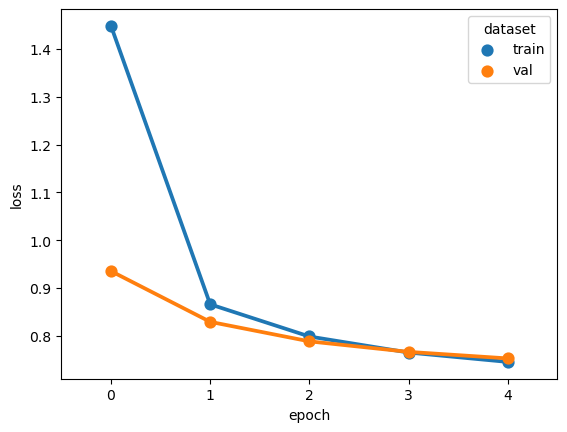

In [26]:
data = []
for epoch, (train_loss, val_loss) in enumerate(zip(
        experiment['train_loss'], experiment['val_loss'])):
    data.append((epoch, 'train', train_loss[1]))
    data.append((epoch, 'val', val_loss[1]))
data = pd.DataFrame(data=data, columns=['epoch', 'dataset', 'loss'])
seaborn.pointplot(
    data=data, x='epoch', y='loss', hue='dataset'
)

En este práctico dicidimos utilizar una red recurrent para entrenar nuestra red para predecir categorias de MELI a partir de títulos de publicaciones. En cuanto a preprocesamiento de datos definimos exactamente lo mismo que en nuestro modelo MLP. Cuando definimos la red, modificamos el tamaño de la salida de 1 a 632 ya que son la cantidad de clases posibles que tenemos y decidimos entrenar nuestros propios embeddings.

En un primer momento nos dispusimos a probar un modelo simple, probamos un modelo con una configuración similar al ejemplo que vimos en clases, desactivando solamente la función de activación por el hecho de que usamos cross entropy loss y entendemos que ya incorpora una softmax y con esto vimos una loss que bajaba bastante bien train y se veía también bien en test y un accuracy en test de 0.89 por lo que decidimos tomar esta como mejor configuración posible con temor a llegar un overfitting si tratabamos de subir el accuracy.

En el futuro creemos que probar con algunos parametros e incluso cambiando de estructura nos podría ayudar a mejorar nuestras métricas.
